In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
from langchain_core.messages import AIMessage
import os
from openai import OpenAI
from dotenv import load_dotenv
from nodes import assistant, summarize_packets, execute_tools, save_iteration
from state import HoneypotStateReact
from memory import EpisodicMemory
nest_asyncio.apply()
import benchmark as b



def display_graph(graph, width=500, height=600):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-4o",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16,
            timeout=10
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


# Memory implementation

In [3]:
def should_continue_from_assistant(state: HoneypotStateReact) -> Literal["tools", "save_iteration", "__end__"]:
    last_message = state.messages[-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if we have enough data and no cleanup flag
    if (len(state.packet_summary) > 1 and len(state.messages) > 1 and not state.cleanup_flag):
        return "save_iteration"  #
    

    return "__end__"


def should_continue_from_tools(state: HoneypotStateReact) -> Literal["threat_verification", "assistant"]:
    # After tools are executed, decide where to go next
    if state.network_flows and state.security_events and state.compressed_packets and not state.packet_summary:
        return "threat_verification"
    return "assistant"


In [4]:
def cleanup_messages(state: HoneypotStateReact):
    """Clean up messages - simplified for notebook usage"""
    print("Ending iteration...")
    
    # For notebook usage, don't flush state since each epoch starts fresh
    # Just mark cleanup as complete
    return {
        "cleanup_flag": True
    }

In [5]:
def build_react_graph():
    builder = StateGraph(HoneypotStateReact)
    
    # Add nodes (remove save_iteration node)
    builder.add_node("assistant", assistant)
    builder.add_node("tools", execute_tools)
    builder.add_node("threat_verification", summarize_packets)
    builder.add_node("save_iteration", save_iteration)
    builder.add_node("cleanup", cleanup_messages)
    
    # Add edges
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", should_continue_from_assistant)
    builder.add_conditional_edges("tools", should_continue_from_tools)
    builder.add_edge("threat_verification", "assistant")
    builder.add_edge("save_iteration", "cleanup")
    builder.add_edge("cleanup", "__end__")
        
    return builder.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:42061/devtools/browser/bf5fbd6b-1890-431c-963a-ad3fafbd2c3e
INFO:pyppeteer.launcher:terminate chrome process...


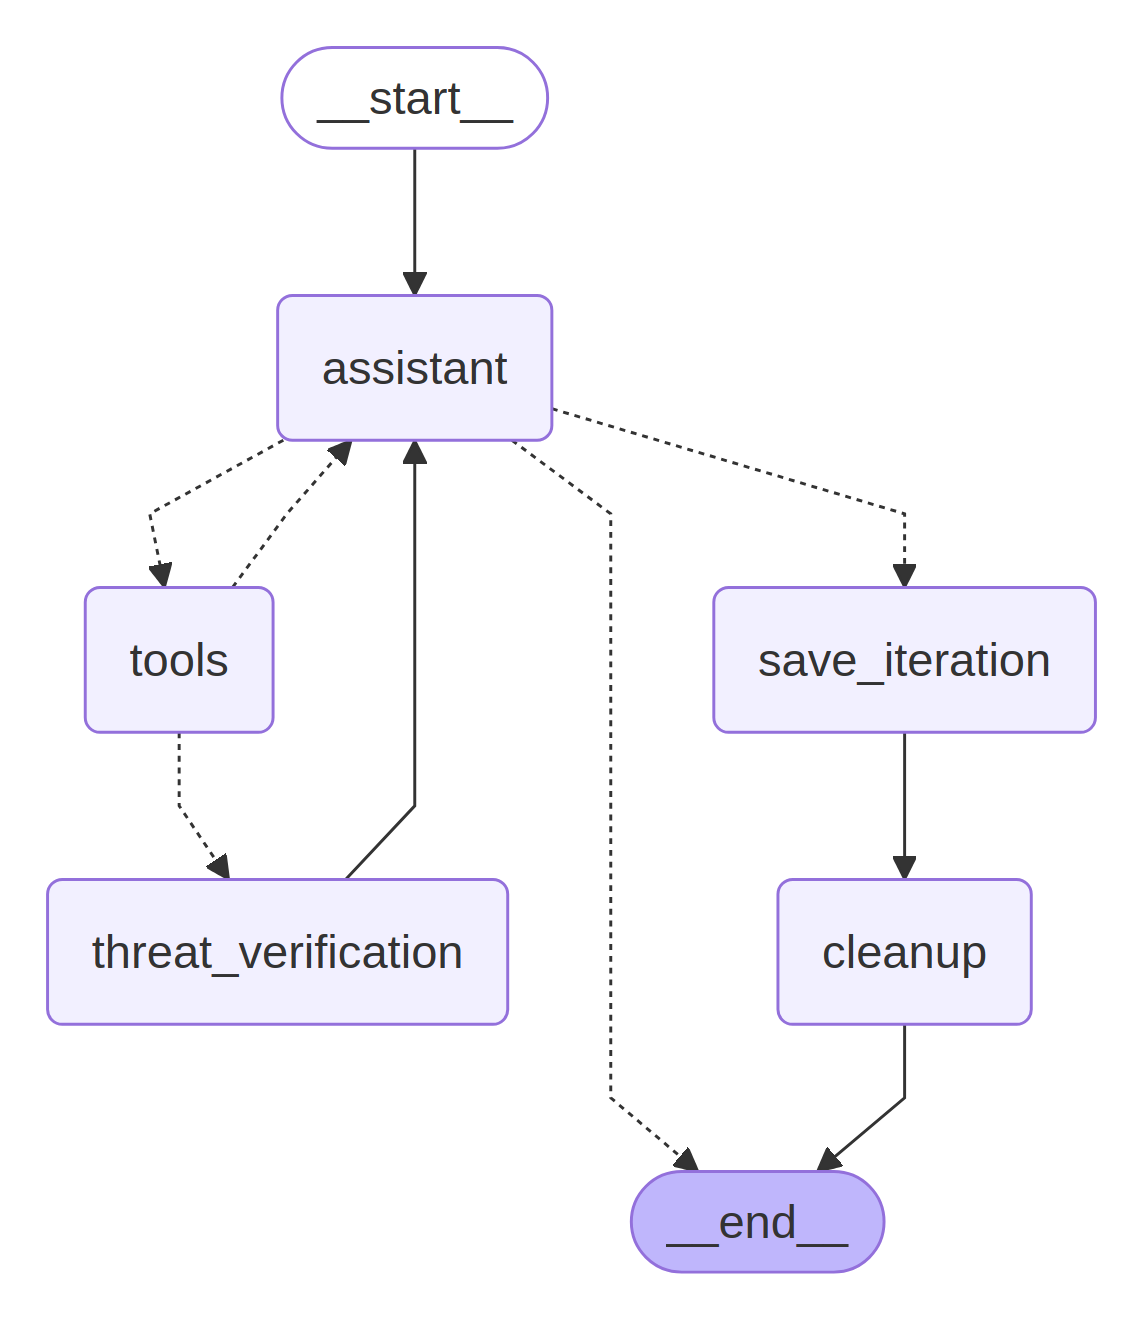

In [6]:
graph = build_react_graph()
display_graph(graph)

In [7]:
# initial_state = HoneypotStateReact(
#     messages="Analyze a time_window=1 for all the tools and actually use the tool for adding firewall rules"
# )
# response = graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})

In [8]:
# for m in response['messages']:
#     m.pretty_print()

# Benchmark

## Gitlab

In [ ]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 10,
            "attack_duration": 200,
            "monitor_accumulation_wait": 1,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Gitlab"
        }

In [12]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:benchmark.AttackerController:[ATTACK-1] [+] Detected v

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.5:80 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.5 -> 192.168.100.2 (all)
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.4:80 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.4 -> 192.168.100.2 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 25, 'service': 'gitlab', 'status': 'RECONNAISSANCE'}, '172.20.0.5': {'percentage': 0, 'service': 'gitlab-proxy', 'status': 'PROXY-NOT-TRACKED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1
INFO:benchmark:Memory from agent: {'id': 'iteration_1', 'iteration_number': 1, 'ti

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] ['/attacker/scripts/manager_exploit.py', '2']
INFO:benchmark.AttackerController:[ATTACK-2] [*] Launching exploit manager...
INFO:benchmark.AttackerControl

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 50, 'service': 'gitlab', 'status': 'INITIAL_ACCESS'}, '172.20.0.5': {'percentage': 0, 'service': 'gitlab-proxy', 'status': 'PROXY-NOT-TRACKED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_2. Total iterations: 2
INFO:benchmark:Memory from agent: {'id': 'iteration_2', 'iteration_number': 2, 'timestamp': 1752679947, 'datetime': '2025-07-16T17:32:27.126779', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 50, 'service': 'gitlab', 'status': 'INITIAL_ACCESS'}, '172.20.0.5': {'percentage': 0, 'service': 'gitlab-proxy', 'status': 'PROXY-NOT-TRACKED'}}, 'decision_rationale': "The attacker has advanced from scanning t

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-3] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-3] ['/attacker/scripts/manager_exploit.py', '3']
INFO:benchmark.AttackerController:[ATTACK-3] [*] Launching exploit manager...
INFO:benchmark.AttackerControl

Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 50, 'service': 'gitlab', 'status': 'INITIAL_ACCESS'}, '172.20.0.5': {'percentage': 0, 'service': 'gitlab-proxy', 'status': 'PROXY-NOT-TRACKED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_3. Total iterations: 3
INFO:benchmark:Memory from agent: {'id': 'iteration_3', 'iteration_number': 3, 'timestamp': 1752680105, 'datetime': '2025-07-16T17:35:05.058410', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 50, 'service': 'gitlab', 'status': 'INITIAL_ACCESS'}, '172.20.0.5': {'percentage': 0, 'service': 'gitlab-proxy', 'status': 'PROXY-NOT-TRACKED'}}, 'decision_rationale': 'Attack progression is stable at initial a

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-4] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-4] ['/attacker/scripts/manager_exploit.py', '4']
INFO:benchmark.AttackerController:[ATTACK-4] [*] Launching exploit manager...
INFO:benchmark.AttackerControl

Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab', 'status': 'FULL_CONTROL'}, '172.20.0.5': {'percentage': 0, 'service': 'gitlab-proxy', 'status': 'PROXY-NOT-TRACKED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_4. Total iterations: 4
INFO:benchmark:Memory from agent: {'id': 'iteration_4', 'iteration_number': 4, 'timestamp': 1752680226, 'datetime': '2025-07-16T17:37:06.652466', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab', 'status': 'FULL_CONTROL'}, '172.20.0.5': {'percentage': 0, 'service': 'gitlab-proxy', 'status': 'PROXY-NOT-TRACKED'}}, 'decision_rationale': 'Evidence from compressed packet payload, th

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-5] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-5] ['/attacker/scripts/manager_exploit.py', '5']
INFO:benchmark.AttackerController:[ATTACK-5] [*] Launching exploit manager...
INFO:benchmark.AttackerControl

Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Processing 2 chunks for comprehensive analysis...
Analyzing chunk 1/2...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 2/2...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.0/24 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab', 'status': 'FULL_CONTROL'}, '172.20.0.5': {'percentage': 0, 'service': 'gitlab-proxy', 'status': 'PROXY-NOT-TRACKED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_5. Total iterations: 5
INFO:benchmark:Memory from agent: {'id': 'iteration_5', 'iteration_number': 5, 'timestamp': 1752680401, 'datetime': '2025-07-16T17:40:01.150741', 'currently_exposed': 'NONE', 'rules_added': ['ALLOW 192.

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab/epoch_005.json
INFO:benchmark.Orchestrator:Lockdown activated - stopping benchmark
INFO:benchmark.Orchestrator:Saved report to benchmark_results/Test Gitlab/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [13]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print("=" * 30)
    print(f"Iteration {i +1}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance']:
            print(f"{k}")
            v_str = str(v)
            for i in range(0, len(v_str), 120):
                print(v_str[i:i+120])
            print("\n")
    print("=" * 30 +"\n")

Iteration 1
decision_rationale
Based on network flows and ARP-based recon, the attacker is in active reconnaissance stage (25% progression). Controlled
 exposure is required to monitor the next stage of exploitation and to collect evidence per the systematic progression g
oal. Only one honeypot is exposed (GitLab, via its proxy) to maintain focused analysis.


justification
Firewall rules are being added to expose the GitLab honeypot (172.20.0.4:80 via the proxy 172.20.0.5:80) for further att
ack progression beyond initial Layer 2/3 reconnaissance. This allows packet and exploit observation in a controlled sett
ing, supporting intelligence gathering at early attack stages.


next_iteration_guidance
Monitor for signs of initial access (successful connection attempts, HTTP traffic on port 80 to 172.20.0.4), and observe
 for any credential, exploit or command activity indicating compromise.



Iteration 2
decision_rationale
The attacker has advanced from scanning to successful file access

## Docker + Struts 

In [11]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 10,
            "attack_duration": 200,
            "monitor_accumulation_wait": 1,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Docker + Struts"
        }

In [12]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:benchmark.AttackerController:[ATTACK-1] [+] Detected v

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.2:2375 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.2 -> 192.168.100.2 (tcp)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 25, 'service': 'docker', 'status': 'RECONNAISSANCE'}, '172.20.0.3': {'percentage': 0, 'service': 'struts2', 'status': 'UNEXPOSED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1
INFO:benchmark:Memory from agent: {'id': 'iteration_1', 'iteration_number': 1, 'timestamp': 1752681406, 'datetime': '2025-07-16T17:56:46.721280', 'currently_exposed': '172.20.0.2:2375', 'rules_added': ['ALLOW 192.168.100.2 -> 172.20.0.2

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] ['/attacker/scripts/manager_exploit.py', '2']
INFO:benchmark.AttackerController:[ATTACK-2] [*] Launching exploit manager...
INFO:benchmark.Attack

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Processing 4 chunks for comprehensive analysis...
Analyzing chunk 1/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 2/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 3/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 4/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 100, 'service': 'docker', 'status': 'FULL_CONTROL'}, '172.20.0.3': {'percentage': 0, 'service': 'struts2', 'status': 'UNEXPOSED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_2. Total iterations: 2
INFO:benchmark:Memory from agent: {'id': 'iteration_2', 'iteration_number': 2, 'timestamp': 1752681573, 'datetime': '2025-07-16T17:59:33.356298', 'currently_exposed': '172.20.0.2:2375', 'rules_added': [], 'attack_graph': {'172.20.0.2': {'percentage': 100, 'service': 'docker', 'status': 'FULL_CONTROL'}, '172.20.0.3': {'percentage': 0, 'service': 'struts2', 'status': 'UNEXPOSED'}},

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-3] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-3] ['/attacker/scripts/manager_exploit.py', '3']
INFO:benchmark.AttackerController:[ATTACK-3] [*] Launching exploit manager...
INFO:benchmark.Attack

Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Processing 3 chunks for comprehensive analysis...
Analyzing chunk 1/3...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 2/3...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 3/3...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.3:8080 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.3 -> 192.168.100.2 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 100, 'service': 'docker', 'status': 'FULL_CONTROL'}, '172.20.0.3': {'percentage': 0, 'service': 'struts2', 'status': 'UNEXPOSED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_3. Total iterations: 3
INFO:benchmark:Memory from agent: {'id': 'iteration_3', 'iteration_number': 3, 'timestamp': 1752681769, 'datetime': '2025-07-16T18:02:49.406339', 

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-4] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-4] ['/attacker/scripts/manager_exploit.py', '4']
INFO:benchmark.AttackerController:[ATTACK-4] [*] Launching exploit manager...
INFO:benchmark.Attack

Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Processing 4 chunks for comprehensive analysis...
Analyzing chunk 1/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 2/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 3/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 4/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 100, 'service': 'docker', 'status': 'FULL_CONTROL'}, '172.20.0.3': {'percentage': 100, 'service': 'struts2', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_4. Total iterations: 4
INFO:benchmark:Memory from agent: {'id': 'iteration_4', 'iteration_number': 4, 'timestamp': 1752681966, 'datetime': '2025-07-16T18:06:06.636005', 'currently_exposed': '172.20.0.3:8080', 'rules_added': [], 'attack_graph': {'172.20.0.2': {'percentage': 100, 'service': 'docker', 'status': 'FULL_CONTROL'}, '172.20.0.3': {'percentage': 100, 'service': 'struts2', 'status': 'FULL_C

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-5] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-5] ['/attacker/scripts/manager_exploit.py', '5']
INFO:benchmark.AttackerController:[ATTACK-5] [*] Launching exploit manager...
INFO:benchmark.Attack

Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Processing 4 chunks for comprehensive analysis...
Analyzing chunk 1/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 2/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 3/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 4/4...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.0/24 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 100, 'service': 'docker', 'status': 'FULL_CONTROL'}, '172.20.0.3': {'percentage': 100, 'service': 'struts2', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_5. Total iterations: 5
INFO:benchmark:Memory from agent: {'id': 'iteration_5', 'iteration_number': 5, 'timestamp': 1752682147, 'datetime': '20

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts/epoch_005.json
INFO:benchmark.Orchestrator:Lockdown activated - stopping benchmark
INFO:benchmark.Orchestrator:Saved report to benchmark_results/Test Docker + Struts/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [13]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print("=" * 30)
    print(f"Iteration {i +1}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance']:
            print(f"{k}")
            v_str = str(v)
            for i in range(0, len(v_str), 120):
                print(v_str[i:i+120])
            print("\n")
    print("=" * 30 +"\n")

Iteration 1
decision_rationale
Decision based on clear evidence of attacker port scanning and initial reconnaissance on Docker. No evidence of successf
ul connection or exploitation; thus, engagement remains at reconnaissance. We expose only the Docker honeypot (172.20.0.
2:2375) to safely monitor and guide attack progression as per strategic doctrine.


justification
Rules added to expose Docker honeypot (172.20.0.2:2375) for controlled attacker engagement. Only reconnaissance activity
 evident (no exploitation or command execution). Exposing a single target maximizes intelligence and preserves containme
nt. Allow rules are synchronized bidirectionally to enable full attack engagement as per protocol.


next_iteration_guidance
Carefully monitor for initial access (TCP handshake/HTTP connection) or signs of Docker exploitation (commands, file acc
ess) targeting 172.20.0.2:2375. Do not rotate target until at least 50% exploitation confirmed or evidence of further st
eps on Docker. Maint

## Docker + Struts + Gitlab

In [8]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 10,
            "attack_duration": 200,
            "monitor_accumulation_wait": 1,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Docker + Struts + Gitlab"
        }

In [12]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run
INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:ben

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.2:2375 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.2 -> 192.168.100.2 (tcp)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 25, 'service': 'Docker', 'status': 'RECONNAISSANCE'}, '172.20.0.6': {'percentage': 0, 'service': 'GitLab', 'status': 'UNEXPOSED'}, '172.20.0.7': {'percentage': 0, 'service': 'GitLab Proxy', 'status': 'UNEXPOSED'}, '172.20.0.3': {'percentage': 0, 'service': 'Struts2', 'status': 'UNEXPOSED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1
INFO:benchmark:Memory from agent: {'id': 'iteration_1', 'iteration_number': 

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] ['/attacker/scripts/manager_exploit.py', '2']
INFO:benchmark.AttackerController:[ATTACK-2] [*] Launching exploit manager...
INFO:benchma

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.7:80 (tcp)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.7 -> 192.168.100.2 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.6:80 (tcp)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.6 -> 192.168.100.2 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 100, 'service': 'Docker', 'status': 'FULL_CONTROL'}, '172.20.0.6': {'percentage': 0, 'service': 'GitLab', 'status

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:[ATTACK-3] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-3] ['/attacker/scripts/manager_exploit.py', '3']
INFO:benchmark.AttackerController:[ATTACK-3] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-3] [*] Scanning 172.20.0.0/25 for open po

Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 100, 'service': 'Docker', 'status': 'FULL_CONTROL'}, '172.20.0.6': {'percentage': 50, 'service': 'GitLab', 'status': 'INITIAL_ACCESS'}, '172.20.0.7': {'percentage': 50, 'service': 'GitLab Proxy', 'status': 'INITIAL_ACCESS'}, '172.20.0.3': {'percentage': 0, 'service': 'Struts2', 'status': 'UNEXPOSED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_3. Total iterations: 3
INFO:benchmark:Memory from agent: {'id': 'iteration_3', 'iteration_number': 3, 'timestamp': 1752683160, 'datetime': '2025-07-16T18:26:00.881219', 'currently_exposed': '172.20.0.6:80', 'rules_added': [], 'attack_graph': {'172.20.0.2': {'percentage': 100, 'service': 'Docker', 'status': 'FULL_CONTROL'},

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-4] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-4] ['/attacker/scripts/manager_exploit.py', '4']
INFO:benchmark.AttackerController:[ATTACK-4] [*] Launching exploit manager...
INFO:benchma

Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.3:8080 (tcp)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.3 -> 192.168.100.2 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 100, 'service': 'Docker', 'status': 'FULL_CONTROL'}, '172.20.0.6': {'percentage': 50, 'service': 'GitLab', 'status': 'INITIAL_ACCESS'}, '172.20.0.7': {'percentage': 50, 'service': 'GitLab Proxy', 'status': 'INITIAL_ACCESS'}, '172.20.0.3': {'percentage': 0, 'service': 'Struts2', 'status': 'UNEXPOSED'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iterati

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-5] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-5] ['/attacker/scripts/manager_exploit.py', '5']
INFO:benchmark.AttackerController:[ATTACK-5] [*] Launching exploit manager...
INFO:benchma

Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Processing 3 chunks for comprehensive analysis...
Analyzing chunk 1/3...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 2/3...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 3/3...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.0/24 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.2': {'percentage': 100, 'service': 'Docker', 'status': 'FULL_CONTROL'}, '172.20.0.6': {'percentage': 100, 'service': 'GitLab', 'status': 'FULL_CONTROL'}, '172.20.0.7': {'percentage': 100, 'service': 'GitLab Proxy', 'status': 'FULL_CONTROL'}, '172.20.0.3': {'percentage': 100, 'service': 'Struts2', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_5. Total iterations: 5
INFO:benchmark:Memory from agent: {'id':

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab/epoch_005.json
INFO:benchmark.Orchestrator:Lockdown activated - stopping benchmark
INFO:benchmark.Orchestrator:Saved report to benchmark_results/Test Docker + Struts + Gitlab/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [13]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print("=" * 30)
    print(f"Iteration {i +1}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance']:
            print(f"{k}")
            v_str = str(v)
            for i in range(0, len(v_str), 120):
                print(v_str[i:i+120])
            print("\n")
    print("=" * 30 +"\n")

Iteration 1
decision_rationale
Enabling bi-directional access to Docker on port 2375 increases the likelihood of capturing further attack phases, inclu
ding exploitation and possible container management attempts, key to full attack graph coverage. As no honeypot has reac
hed 100% exploitation, controlled exposure is optimal.


justification
Rules were added to strategically expose the Docker honeypot (port 2375), as current activity is limited to reconnaissan
ce and connection attempts, not exploitation. This step enables collection of exploitation phase intelligence while moni
toring for escalation.


next_iteration_guidance
Carefully monitor for exploitation/compromise attempts (HTTP POSTs, container creation, command execution) via the Docke
r API on 172.20.0.2:2375 from 192.168.100.2. Do not expose next honeypot until Docker reaches 100%.



Iteration 2
decision_rationale
Strategic honeypot rotation: Docker has reached full exploitation and yielded maximum intelligence (all attack

## Test Gitlab - only user access

In [7]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 20,
            "attack_duration": 200,
            "monitor_accumulation_wait": 1,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Gitlab - only user access"
        }

In [8]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run
INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:ben

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.5:80 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.5 -> 192.168.100.2 (all)
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.4:80 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.4 -> 192.168.100.2 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 25, 'service': 'gitlab (via proxy)', 'status': 'RECONNAISSANCE'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1
INFO:benchmark:Memory from agent: {'id': 'iteration_1', 'iteration_number': 1, 'timestamp': 1752684340, 'datetime': '2025-07-16T18:45:40.295294', 'currently_expo

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] ['/attacker/scripts/manager_exploit.py', '2']
INFO:benchmark.AttackerController:[ATTACK-2] [*] Launching exploit manager...
INFO:benchm

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 25, 'service': 'gitlab (via proxy)', 'status': 'RECONNAISSANCE'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_2. Total iterations: 2
INFO:benchmark:Memory from agent: {'id': 'iteration_2', 'iteration_number': 2, 'timestamp': 1752684434, 'datetime': '2025-07-16T18:47:14.698840', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 25, 'service': 'gitlab (via proxy)', 'status': 'RECONNAISSANCE'}}, 'decision_rationale': "Maintain single honeypot exposure and current access rules for 172.20.0.4 (Gitlab via 172.20.0.5 proxy). All evidence indicates persistent reconnaissance only; no successful connections, authenticati

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-3] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-3] ['/attacker/scripts/manager_exploit.py', '3']
INFO:benchmark.AttackerController:[ATTACK-3] [*] Launching exploit manager...
INFO:benchm

Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 50, 'service': 'gitlab (via proxy)', 'status': 'INITIAL_ACCESS'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_3. Total iterations: 3
INFO:benchmark:Memory from agent: {'id': 'iteration_3', 'iteration_number': 3, 'timestamp': 1752684534, 'datetime': '2025-07-16T18:48:54.342188', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 50, 'service': 'gitlab (via proxy)', 'status': 'INITIAL_ACCESS'}}, 'decision_rationale': 'Advancing coverage to 50% (INITIAL_ACCESS) is justified by evidence of a successful TCP connection and sensitive-file read probe against /home/ctf/user.txt, which aligns with typical CTF/honeypot att

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-4] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-4] ['/attacker/scripts/manager_exploit.py', '4']
INFO:benchmark.AttackerController:[ATTACK-4] [*] Launching exploit manager...
INFO:benchm

Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 50, 'service': 'gitlab (via proxy)', 'status': 'INITIAL_ACCESS'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_4. Total iterations: 4
INFO:benchmark:Memory from agent: {'id': 'iteration_4', 'iteration_number': 4, 'timestamp': 1752684604, 'datetime': '2025-07-16T18:50:04.962736', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 50, 'service': 'gitlab (via proxy)', 'status': 'INITIAL_ACCESS'}}, 'decision_rationale': 'Monotonic advancement is enforced true to policy: Previous evidence justified 50% (INITIAL_ACCESS) for Gitlab, but current evidence shows only sustained session establishment and low-confidence application probes. No privilege escalation or exploitation beyond regular session management de

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-5] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-5] ['/attacker/scripts/manager_exploit.py', '5']
INFO:benchmark.AttackerController:[ATTACK-5] [*] Launching exploit manager...
INFO:benchm

Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 50, 'service': 'gitlab (via proxy)', 'status': 'INITIAL_ACCESS'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_5. Total iterations: 5
INFO:benchmark:Memory from agent: {'id': 'iteration_5', 'iteration_number': 5, 'timestamp': 1752684726, 'datetime': '2025-07-16T18:52:06.921850', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 50, 'service': 'gitlab (via proxy)', 'status': 'INITIAL_ACCESS'}}, 'decision_rationale': 'Maintaining exposure of the Gitlab honeypot is justified by evidence of successful user-level file read attempts and path traversal, but no root/shell or system takeover has occurred. This aligns wit

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_005.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 6 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-6] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-6] ['/attacker/scripts/manager_exploit.py', '6']
INFO:benchmark.AttackerController:[ATTACK-6] [*] Launching exploit manager...
INFO:benchm

Executing agent for epoch 6
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 66, 'service': 'gitlab (via proxy)', 'status': 'COMPROMISE'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_6. Total iterations: 6
INFO:benchmark:Memory from agent: {'id': 'iteration_6', 'iteration_number': 6, 'timestamp': 1752684819, 'datetime': '2025-07-16T18:53:39.463267', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 66, 'service': 'gitlab (via proxy)', 'status': 'COMPROMISE'}}, 'decision_rationale': "Based on direct payload evidence of local file access targeting '/home/ctf/user.txt', the exploitation state for Gitlab advances to COMPROMISE (66%). This represents an escalation from previous user-level pr

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_006.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 7 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-7] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-7] ['/attacker/scripts/manager_exploit.py', '7']
INFO:benchmark.AttackerController:[ATTACK-7] [*] Launching exploit manager...
INFO:benchm

Executing agent for epoch 7
Loaded 6 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_7. Total iterations: 7
INFO:benchmark:Memory from agent: {'id': 'iteration_7', 'iteration_number': 7, 'timestamp': 1752684929, 'datetime': '2025-07-16T18:55:29.283283', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'Attack graph progression is monotonic and warranted based on high-confidence evidence (payloads, network flows) of path traversal/file compromise, matching the definition for 100% progression as per CT

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_007.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 8 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-8] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-8] ['/attacker/scripts/manager_exploit.py', '8']
INFO:benchmark.AttackerController:[ATTACK-8] [*] Launching exploit manager...
INFO:benchm

Executing agent for epoch 8
Loaded 7 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.2 -> 172.20.0.4:8080 (tcp)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.4 -> 192.168.100.2 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_8. Total iterations: 8
INFO:benchmark:Memory from agent: {'id': 'iteration_8', 'iteration_number': 8, 'timestamp': 1752685026, 'datetime': '2025-07-16T18:57:06.281499', 'currently_exposed': '172.20.0.4:80', 'rules_added': ['ALLOW 172.20.0.4 -> 192.168.100.2 (all)'], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_008.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 9 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-9] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-9] ['/attacker/scripts/manager_exploit.py', '9']
INFO:benchmark.AttackerController:[ATTACK-9] [*] Launching exploit manager...
INFO:benchm

Executing agent for epoch 9
Loaded 8 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_9. Total iterations: 9
INFO:benchmark:Memory from agent: {'id': 'iteration_9', 'iteration_number': 9, 'timestamp': 1752685118, 'datetime': '2025-07-16T18:58:38.109300', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'All attack graph steps for the only available honeypot (Gitlab) have been reached in a monotonic, evidence-driven progression. Attacker has exploited all major phases and exhaustive monitoring confirms

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_009.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 10 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-10] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-10] ['/attacker/scripts/manager_exploit.py', '10']
INFO:benchmark.AttackerController:[ATTACK-10] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 10
Loaded 9 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_10. Total iterations: 10
INFO:benchmark:Memory from agent: {'id': 'iteration_10', 'iteration_number': 10, 'timestamp': 1752685201, 'datetime': '2025-07-16T19:00:01.670163', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'Maximum logical attack graph coverage has been reached for the honeypots in this environment. Full interactive shell access is verified. Existing rules properly expose all required surfaces. No fur

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_010.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 11 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-11] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-11] ['/attacker/scripts/manager_exploit.py', '11']
INFO:benchmark.AttackerController:[ATTACK-11] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 11
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_11. Total iterations: 11
INFO:benchmark:Memory from agent: {'id': 'iteration_11', 'iteration_number': 11, 'timestamp': 1752685298, 'datetime': '2025-07-16T19:01:38.376763', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'Intelligence objective on core vulnerable surface (Gitlab) fully met. No new honeypots available for analysis or rotation. Exposure for ongoing monitoring is permitted under policy, but coverage is complete per protocol—final step before lockdown if environment remains static.', 'lockdow

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_011.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 12 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-12] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-12] ['/attacker/scripts/manager_exploit.py', '12']
INFO:benchmark.AttackerController:[ATTACK-12] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 12
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_12. Total iterations: 12
INFO:benchmark:Memory from agent: {'id': 'iteration_12', 'iteration_number': 12, 'timestamp': 1752685367, 'datetime': '2025-07-16T19:02:47.676922', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'No escalation, code execution, or destructive activity observed. All evidence aligns with FULL_CONTROL on Gitlab as in previous epochs. No new honeypots available for attack graph progression. Current rules preserve optimal exposure for continued intelligence capture, and monotonic advan

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_012.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 13 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-13] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-13] ['/attacker/scripts/manager_exploit.py', '13']
INFO:benchmark.AttackerController:[ATTACK-13] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 13
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_13. Total iterations: 13
INFO:benchmark:Memory from agent: {'id': 'iteration_13', 'iteration_number': 13, 'timestamp': 1752685504, 'datetime': '2025-07-16T19:05:04.583172', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'Maintaining current firewall rules is optimal; attack graph completion for all available honeypots documented in memory with no sign of destructive or privilege escalation activity. No new honeypot

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_013.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 14 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-14] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-14] ['/attacker/scripts/manager_exploit.py', '14']
INFO:benchmark.AttackerController:[ATTACK-14] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 14
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_14. Total iterations: 14
INFO:benchmark:Memory from agent: {'id': 'iteration_14', 'iteration_number': 14, 'timestamp': 1752685576, 'datetime': '2025-07-16T19:06:16.599869', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'No evidence of new exploitation stages. Full attack graph coverage for Gitlab has been maintained in strict monotonic progression according to memory context. No other honeypot available for rotation. Maintaining bidirectional HTTP/proxy exposure ensures ongoing intelligence capture per 

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_014.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 15 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-15] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-15] ['/attacker/scripts/manager_exploit.py', '15']
INFO:benchmark.AttackerController:[ATTACK-15] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 15
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_15. Total iterations: 15
INFO:benchmark:Memory from agent: {'id': 'iteration_15', 'iteration_number': 15, 'timestamp': 1752685647, 'datetime': '2025-07-16T19:07:27.576632', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'Maintaining current firewall policy is optimal since no evidence of new exploitation (no RCE or escalation) and no new honeypots have appeared. Attack graph coverage for the single available honeypot remains at 100%. Single focus enforced; no escalation or lateral movement seen. Lockdown

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_015.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 16 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-16] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-16] ['/attacker/scripts/manager_exploit.py', '16']
INFO:benchmark.AttackerController:[ATTACK-16] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 16
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_16. Total iterations: 16
INFO:benchmark:Memory from agent: {'id': 'iteration_16', 'iteration_number': 16, 'timestamp': 1752685749, 'datetime': '2025-07-16T19:09:09.955658', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'No new honeypot assets are present, and exhaustive monitoring confirms attacker activity is confined to persistent, non-destructive HTTP/HTTPS probes. Attack graph coverage is complete (100%) for all available infrastructures. The environment remains static: rules are already optimal for

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_016.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 17 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-17] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-17] ['/attacker/scripts/manager_exploit.py', '17']
INFO:benchmark.AttackerController:[ATTACK-17] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 17
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_17. Total iterations: 17
INFO:benchmark:Memory from agent: {'id': 'iteration_17', 'iteration_number': 17, 'timestamp': 1752685857, 'datetime': '2025-07-16T19:10:57.216667', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'No additional action justified: full attack graph progression for this environment already achieved, and all current firewall rules are compliant with single-focus, bidirectional exposure policy. O

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_017.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 18 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-18] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-18] ['/attacker/scripts/manager_exploit.py', '18']
INFO:benchmark.AttackerController:[ATTACK-18] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 18
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_18. Total iterations: 18
INFO:benchmark:Memory from agent: {'id': 'iteration_18', 'iteration_number': 18, 'timestamp': 1752685960, 'datetime': '2025-07-16T19:12:40.036146', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'Every stage—recon, initial access, compromise, and full user-level control—has been proven, and research goals are met for the only available asset. Persistent remote shell sessions warrant ongoing

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_018.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 19 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-19] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-19] ['/attacker/scripts/manager_exploit.py', '19']
INFO:benchmark.AttackerController:[ATTACK-19] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 19
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_19. Total iterations: 19
INFO:benchmark:Memory from agent: {'id': 'iteration_19', 'iteration_number': 19, 'timestamp': 1752686063, 'datetime': '2025-07-16T19:14:23.628228', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'Maintaining current firewall rules is optimal and required. All possible attack progression and intelligence goals for the current honeypot have been satisfied per memory, evidence, and protocol. C

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_019.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 20 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-20] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-20] ['/attacker/scripts/manager_exploit.py', '20']
INFO:benchmark.AttackerController:[ATTACK-20] [*] Launching exploit manager...
INFO:b

Executing agent for epoch 20
Loaded 10 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving compressed packets (limit: 1000, window: 5)


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Attack graph: {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_20. Total iterations: 20
INFO:benchmark:Memory from agent: {'id': 'iteration_20', 'iteration_number': 20, 'timestamp': 1752686145, 'datetime': '2025-07-16T19:15:45.270744', 'currently_exposed': '172.20.0.4:80', 'rules_added': [], 'attack_graph': {'172.20.0.4': {'percentage': 100, 'service': 'gitlab (via proxy)', 'status': 'FULL_CONTROL'}}, 'decision_rationale': 'Maintaining current firewall policy: the attack graph remains at 100% for the only target, evidence confirms persistent user-level compromise, and no new escalation or lateral movement is present. 

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab - only user access/epoch_020.json
INFO:benchmark.Orchestrator:Saved report to benchmark_results/Test Gitlab - only user access/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [9]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print("=" * 30)
    print(f"Iteration {i +1}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance']:
            print(f"{k}")
            v_str = str(v)
            for i in range(0, len(v_str), 120):
                print(v_str[i:i+120])
            print("\n")
    print("=" * 30 +"\n")

Iteration 1
decision_rationale
Intelligence objective on core vulnerable surface (Gitlab) fully met. No new honeypots available for analysis or rotatio
n. Exposure for ongoing monitoring is permitted under policy, but coverage is complete per protocol—final step before lo
ckdown if environment remains static.


justification
Firewall rules for bidirectional exposure to Gitlab and proxy are necessary to continue behavioral capture in case of at
tacker re-entry or persistent sessions. Strategic objective achieved for current honeypot; rotation blocked by environme
nt limits.


next_iteration_guidance
Monitor for unplanned honeypot deployment or attacker lateral movement/destructive action; if no new honeypot appears, i
nitiate lockdown next. No additional exposure/rotation possible in current setup.



Iteration 2
decision_rationale
No escalation, code execution, or destructive activity observed. All evidence aligns with FULL_CONTROL on Gitlab as in p
revious epochs. No new honeypots ava